In [12]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Mots d'état"

mots_etat = [
    "En production",
    "Prêt à produire",
    "En panne",
    "Saturation",
    "Désamorçage"
]

In [15]:
# Définition de la classe Equipement : objet prenant en entrée :
# Un ou plusieurs objets de type produit A, B, C caractérisés par des quantités et des unités (m, kg, pcs)
# Une BoM (Bill of Material) indiquant les quantités de produits A, B, C nécessaires pour fabriquer un produit D
# Un temps de cycle : nombre de minutes pour transformer les quantités de produits A, B, C en un produit D
# La représentation de l'équipement est la suivante :
# Un dictionnaire "inputs" ayant pour clés les produits A, B, C et pour valeurs les quantités et unités associées disponibles dans la machine
# Un dictionnaire "BoM" ayant pour clés les produits A, B, C et pour valeurs les quantités consommées pour fabriquer une unité du produit D
# Un dictionnaire "output" ayant pour clés le produit D et pour valeurs les quantités et unités produites par la machine
# Une fonction de production qui réalise un pas de temps de production et met à jour les quantités de produits disponibles dans la machine

class Equipement:
    def __init__(self, name, inputs, BoM, outputs, cycle_time, WIP_capacity, inputs_capacity, outputs_capacity):
        # Paramètres de l'équipement
        self.name = name
        self.BoM = BoM
        self.WIP_capacity = WIP_capacity
        # self.inputs_capacity = inputs_capacity
        self.outputs_capacity = outputs_capacity
        self.inputs_nb_positions = {product: inputs_capacity[product][0] for product in inputs_capacity}

        # Etats de l'équipement
        self.inputs = inputs
        self.outputs = outputs
        self.WIP = []
        self.status_word = "Prêt à produire"
        self.cycle_time = cycle_time
        self.inputs_position = {inputs_product: 0 for inputs_product in inputs}

    def consomption(self):
        # On vérifie que l'équipement a bien les quantités nécessaires pour produire un produit
        if len(self.WIP) < self.WIP_capacity:
            if all(self.inputs[product][0][self.inputs_position[product]] >= self.BoM[product] for product in self.BoM):
                self.status_word = "En production"
                # On consomme les quantités nécessaires pour produire un produit
                for product in self.BoM:
                    self.inputs[product][0][self.inputs_position[product]] -= self.BoM[product]
                # On produit un produit
                self.WIP.append([{output_product: 1 for output_product in self.outputs.keys()}, self.cycle_time]) # liste (output batch sans temps, temps restant)
            else:
                self.status_word = "Désamorçage"
        else:
            self.status_word = "Saturation"
    
    def production_step(self):
        # Avancement des encours dans le process
        for output_batch in self.WIP:
            output_batch[1] -= 1
            # product[1] -= 1

        # Déchargement des produits terminés si la capacité de stockage pied de ligne le permet
        if all(self.outputs[outputs_product][0] < self.outputs_capacity[outputs_product][0] for outputs_product in self.outputs):
            for output_batch in self.WIP:
                # Si le batch a fini son cycle on le bascule en stock pied de ligne
                if output_batch[1] <= 0:
                    for outputs_product in output_batch[0]:
                        self.outputs[outputs_product][0] += output_batch[0][outputs_product]

                    self.WIP.remove(output_batch)
                    self.status_word = "En production"
        else:
            self.status_word = "Saturation"

        self.consomption()

    def select_inputs_position(self):
        pass
    
    def __str__(self):
        return self.name
    
    def __repr__(self):
        return self.name
    
    def status(self):
        print("Inputs : ", self.inputs)
        print("WIP : ", self.WIP)
        print("Outputs : ", self.outputs)
        print("Mot d'état : ", self.status_word)
        print("\n")

In [45]:
# Test de la classe Equipement avec une stackeuse

inputs = {"Bande notchée anode": [[1000, 2000], "m"], "Bande notchée cathode": [[2000, 2000], "m"], "Séparateur": [[3000], "m"]}
outputs = {"Stacks": [0, "pcs"]}
BoM = {"Bande notchée anode": 10, "Bande notchée cathode": 10, "Séparateur": 20}
cycle_time = 3 # 3 minutes pour produire un stack
WIP_capacity = 4
inputs_capacity = {"Bande notchée anode": [2, "bobines"], "Bande notchée cathode": [2, "bobines"], "Séparateur": [2, "bobines"]}
outputs_capacity = {"Stacks": [5, "pcs"]}

stackeuse = Equipement("Stacking_1", inputs, BoM, outputs, cycle_time, WIP_capacity, inputs_capacity, outputs_capacity)

for i in range(15):
    stackeuse.production_step()
    stackeuse.status()

Inputs :  {'Bande notchée anode': [[990, 2000], 'm'], 'Bande notchée cathode': [[1990, 2000], 'm'], 'Séparateur': [[2980], 'm']}
WIP :  [[{'Stacks': 1}, 3]]
Outputs :  {'Stacks': [0, 'pcs']}
Mot d'état :  En production


Inputs :  {'Bande notchée anode': [[980, 2000], 'm'], 'Bande notchée cathode': [[1980, 2000], 'm'], 'Séparateur': [[2960], 'm']}
WIP :  [[{'Stacks': 1}, 2], [{'Stacks': 1}, 3]]
Outputs :  {'Stacks': [0, 'pcs']}
Mot d'état :  En production


Inputs :  {'Bande notchée anode': [[970, 2000], 'm'], 'Bande notchée cathode': [[1970, 2000], 'm'], 'Séparateur': [[2940], 'm']}
WIP :  [[{'Stacks': 1}, 1], [{'Stacks': 1}, 2], [{'Stacks': 1}, 3]]
Outputs :  {'Stacks': [0, 'pcs']}
Mot d'état :  En production


Inputs :  {'Bande notchée anode': [[960, 2000], 'm'], 'Bande notchée cathode': [[1960, 2000], 'm'], 'Séparateur': [[2920], 'm']}
WIP :  [[{'Stacks': 1}, 1], [{'Stacks': 1}, 2], [{'Stacks': 1}, 3]]
Outputs :  {'Stacks': [1, 'pcs']}
Mot d'état :  En production


Inputs :  {'Band

In [51]:
# Classe simulation permettant de simuler le fonctionnement de la machine et d'en enregistrer et afficher certains états

class Simulation:
    def __init__(self, equipements=[], duration=100):
        self.equipements = equipements
        self.duration = duration
        self.equipements_states = {equipement: dict() for equipement in self.equipements}

        for equipement in self.equipements:
            self.equipements_states[equipement]["Status Word"] = []
            self.equipements_states[equipement]["Inputs"] = []
            self.equipements_states[equipement]["WIP"] = []
            self.equipements_states[equipement]["Outputs"] = []
    
    def save_states(self, equipement):
        self.equipements_states[equipement]["Status Word"].append(equipement.status_word)
        self.equipements_states[equipement]["Inputs"].append([sum(equipement.inputs[product][0]) for product in equipement.inputs])
        self.equipements_states[equipement]["WIP"].append(sum([sum(batch[0][product] for product in batch[0]) for batch in equipement.WIP]))
        self.equipements_states[equipement]["Outputs"].append([equipement.outputs[product][0] for product in equipement.outputs])
    
    def run(self):
        for _ in range(self.duration):
            for equipement in self.equipements:
                equipement.production_step()
                # equipement.status()
                self.save_states(equipement)
    
    def plot(self, equipement, state):
        plt.plot(self.equipements_states[equipement][state])
        plt.xlabel("Time")
        plt.ylabel(state)
        plt.title(f"{equipement} {state}")
        plt.show()

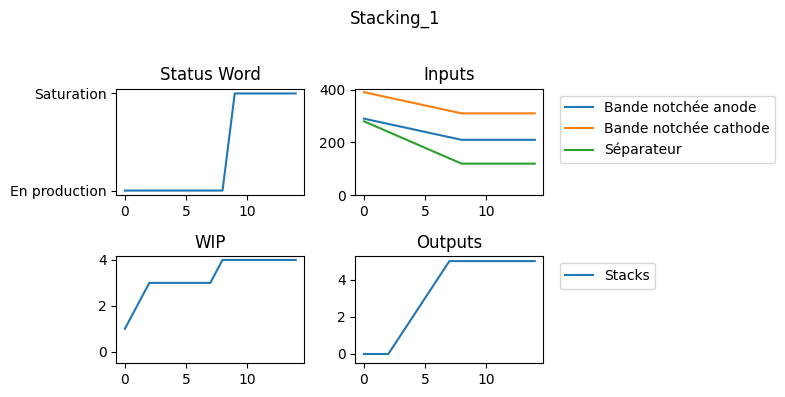

In [79]:
inputs = {"Bande notchée anode": [[100, 200], "m"], "Bande notchée cathode": [[200, 200], "m"], "Séparateur": [[300], "m"]}
outputs = {"Stacks": [0, "pcs"]}
BoM = {"Bande notchée anode": 10, "Bande notchée cathode": 10, "Séparateur": 20}
cycle_time = 3 # 3 minutes pour produire un stack
WIP_capacity = 4
inputs_capacity = {"Bande notchée anode": [2, "bobines"], "Bande notchée cathode": [2, "bobines"], "Séparateur": [2, "bobines"]}
outputs_capacity = {"Stacks": [5, "pcs"]}

stackeuse = Equipement("Stacking_1", inputs, BoM, outputs, cycle_time, WIP_capacity, inputs_capacity, outputs_capacity)

sim = Simulation([stackeuse], 15)
sim.run()

# sim.plot(stackeuse, "WIP")
# sim.plot(stackeuse, "Status Word")
# sim.plot(stackeuse, "Inputs")
# sim.plot(stackeuse, "Outputs")

# Subplot avec 4 cases : 1 : Status Word, 2 : Inputs, 3 : WIP, 4 : Outputs

fig, axs = plt.subplots(2, 2, figsize=(8, 4))

fig.suptitle(stackeuse)

axs[0, 0].plot(sim.equipements_states[stackeuse]["Status Word"])
axs[0, 0].set_title("Status Word")

axs[0, 1].plot(sim.equipements_states[stackeuse]["Inputs"])
axs[0, 1].set_ylim(bottom=0)
axs[0, 1].legend([product for product in stackeuse.inputs], bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0, 1].set_title("Inputs")

axs[1, 0].plot(sim.equipements_states[stackeuse]["WIP"])
axs[1, 0].set_ylim(bottom=-0.5)
axs[1, 0].set_title("WIP")

axs[1, 1].plot(sim.equipements_states[stackeuse]["Outputs"])
axs[1, 1].set_ylim(bottom=-0.5)
axs[1, 1].legend([product for product in stackeuse.outputs], bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1, 1].set_title("Outputs")

# Amélioration visuelle (traits et texte plus fins)
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()